Autoencoders are a specific type of feedforward neural networks where the input is the same as the output. They compress the input into a lower-dimensional code and then reconstruct the output from this representation. The code is a compact “summary” or “compression” of the input, also called the latent-space representation.

## Imports

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [16]:
transform = transforms.ToTensor()

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ])

# Load the data
# Change download=True if you don't already have the MNIST dataset.
mnist_data = datasets.MNIST(root='./data', train=True, download=False, transform=transform) 

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                         batch_size=64,
                                         shuffle=True)

In [17]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In this project we are going to use a feedforward Neural network and a Convolutional Neural Network then train our model and compare the results.

## Using a feedforward Neural Network

In [26]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
    
        self.decoder = nn.Sequential(
            nn.Linear(3, 12), 
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid() # N, 3 -> 784
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
       
# Note: [-1, 1] -> nn.Tanh

## Using a Convolutional Neural Network

In [27]:
class Autoencoder(nn.Module):
    def __init__(self):
        # N, 1, 28, 28
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # N, 64, 1, 1
        )
    
        # N, 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
       
# Note: [-1, 1] -> nn.Tanh
# nn.MaxPool2d -> nn.Maxpool2d

In [28]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

## Training

In [29]:
%%time

num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0070
Epoch:2, Loss:0.0050
Epoch:3, Loss:0.0038
Epoch:4, Loss:0.0034
Epoch:5, Loss:0.0031
Epoch:6, Loss:0.0035
Epoch:7, Loss:0.0026
Epoch:8, Loss:0.0030
Epoch:9, Loss:0.0028
Epoch:10, Loss:0.0030
Wall time: 16min 38s


## Plotting the images

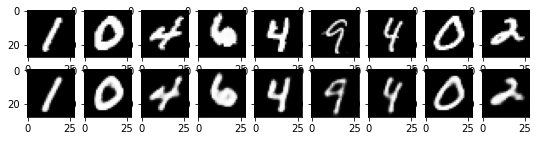

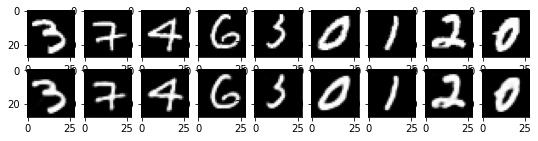

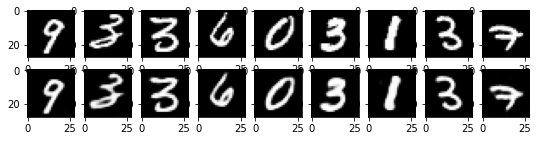

In [30]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9,2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy() # This is a torch tensor that we convert to a numpy array for plotting.
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs): # We iterate over the images and plot the first 9 images.
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item: 1, 28, 28
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item: 1, 28, 28
        plt.imshow(item[0])

From these results we can see that Convolutional Neural Networks performs better than a normal feedforward neural network.